# Siamese postprocess

In [1]:
import re
import itertools
import random
import importlib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import PIL
import tifffile
import torch
import torchvision
import umap

%matplotlib inline

# plot model performance

In [2]:
def log2df(logfile):
    epoch = 0
    row_list = []

    with open(logfile) as f:
        line = f.readline()
        while not line.startswith('[End]'):
            if line.startswith('Epoch'):
                epoch += 1
                line1 = f.readline()
                line2 = f.readline()
                if not line2:
                    break
                
                g = re.search(r"patch-loss: (.*)", line1).group(1)
                row_list.append([epoch, 'train', float(g)])
                
                g = re.search(r"patch-loss: (.*)", line2).group(1)
                row_list.append([epoch, 'val', float(g)])

            line = f.readline()
            if not line:
                break
    
    df = pd.DataFrame(row_list, columns=['epoch', 'phase', 'patch-loss'])

    return df

In [3]:
def plot(logfile, title, figsize=(6, 5)):    
    df = log2df(logfile)
    
    sns.set(font_scale=1.5)
    plt.figure(figsize=figsize)

    ax = sns.lineplot(data=df, x='epoch', y='patch-loss', 
                      style='phase', style_order=['val', 'train'])
    
    plt.title(title)

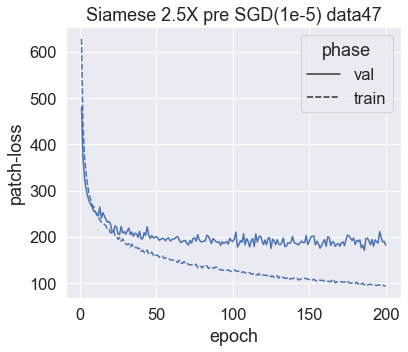

In [47]:
plot('../model/siamese/20201029_1752.log', 
     'Siamese 2.5X pre SGD(1e-5) data47')

# MSI probability

In [5]:
from model_resnet18 import PathologyModel

pmodel = PathologyModel('../model/overlap_2.5X/20200910_1224.ini')
pmodel.model.load_state_dict(torch.load('../model/overlap_2.5X/20200910_1224_epoch8.pth'))

logfile:       E:/PAIP2020/model/overlap_2.5X/20201104_1533.log


<All keys matched successfully>

In [6]:
%%time

dataset, dataloader = pmodel.make_dataloader('../data/dataset_trainval/patch_level2.csv', 'inference')
patch_loss, patch_acc, wsi_auc, wsi_f1, df_prob = pmodel.inference(dataloader)

print(df_prob.shape)
df_prob.head(1)

(6276, 11)
Wall time: 1min 30s


wsi  msi      prob      loss      x      y  size  level  pred  \
0  training_data_01    1  0.275975  0.653247  49152  65536   256      2     0   

   wsi_prob  wsi_pred  
0  0.597561         1

# Encoder

In [2]:
from model_siamese import PathologyModel

pmodel = PathologyModel('../model/siamese/20201029_1752.ini')
pmodel.model.load_state_dict(torch.load('../model/siamese/20201029_1752_best.pth'))

logfile:       E:/PAIP2020/model/siamese/20201104_1554.log


<All keys matched successfully>

In [6]:
%%time

dataset, dataloader = pmodel.make_dataloader('../data/dataset_trainval/patch_level1.csv', 'encoder')
df = dataset.df
feature = pmodel.encoder(dataloader)
feature = feature.cpu().numpy()

df['feature'] = feature.tolist()
df['feature'] = df['feature'].map(np.array)

print(feature.shape)

(104783, 16)
Wall time: 6min 49s


In [9]:
df['prob'] = df_prob['prob']

print(df.shape)
df.head(1)

(6276, 12)


wsi  msi dataset                            patch  level  \
0  training_data_01    1   train  training_data_01_l2_49152_65536      2   

       x      y  size  tumor_ratio  blank_ratio  \
0  49152  65536   256     0.878815     0.088867   

                                                file      prob  
0  PAIP2020/training/patch_level2_256_macenko/tra...  0.275975

# save

In [7]:
df.to_csv('../model/siamese/20201029_1752_encoding.csv', index=False)

# df = pd.read_csv('../model/siamese/20201029_1752_encoding.csv')
# feature

# merge patches

In [36]:
df_wsi = df.groupby(['wsi', 'msi', 'dataset'])['feature'].apply(np.mean).to_frame().reset_index()

print(df_wsi.shape)
df_wsi.head(1)

(76, 4)


wsi  msi dataset  \
0  training_data_01    1   train   

                                             feature  
0  [0.020726210346854314, -0.9750757798915957, -1...

In [39]:
feature_wsi = np.array(df_wsi['feature'].tolist())
feature_wsi.shape

(76, 64)

# UMAP

In [16]:
%%time

feature_train = feature[df['dataset'] == 'train', :]
feature_val = feature[df['dataset'] == 'val', :]

embedding = umap.UMAP().fit_transform(feature)
embedding.shape

Wall time: 1min 11s


(104783, 2)

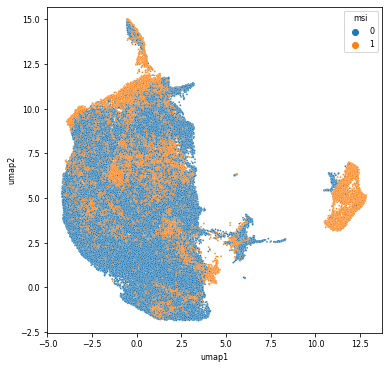

In [17]:
t = df.copy()
# t = t[t['dataset'] == 'val']

t['umap1'] = embedding[:, 0]
t['umap2'] = embedding[:, 1]

t = t.sample(t.shape[0])

plt.figure(figsize=(6, 6))
sns.scatterplot(data=t, x='umap1', y='umap2', hue='msi', s=3)
plt.gca().set_aspect('equal', 'datalim')

# plt.figure(figsize=(6, 6))
# sns.scatterplot(data=t, x='umap1', y='umap2', hue='prob', s=10)
# plt.gca().set_aspect('equal', 'datalim')

In [18]:
t2 = t[t['umap1'] > 10]
print(t2.shape)
t2['wsi'].value_counts()

(5350, 16)


training_data_42      3461
training_data_47      1310
training_data_31       519
training_data_28        14
training_data_26        10
training_data_43         6
training_data_20         4
training_data_09         4
training_data_22         3
training_data_03         2
training_data_12         2
training_data_35         2
training_data_02         2
training_data_17         2
training_data_25         2
training_data_32         2
training_data_34         1
validation_data_05       1
training_data_13         1
validation_data_12       1
training_data_23         1
Name: wsi, dtype: int64

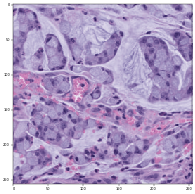

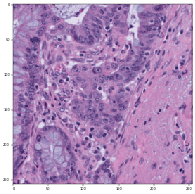

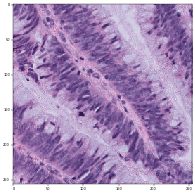

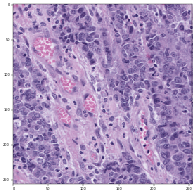

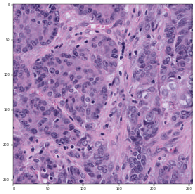

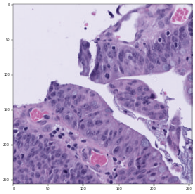

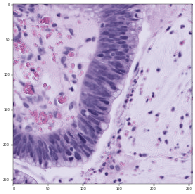

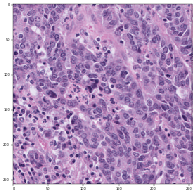

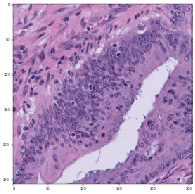

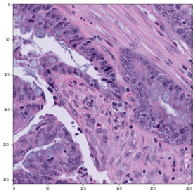

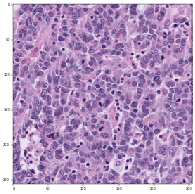

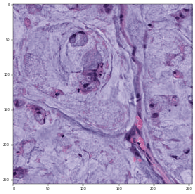

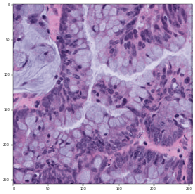

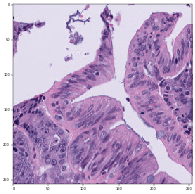

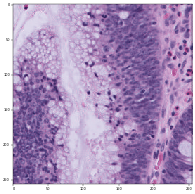

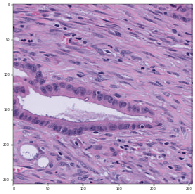

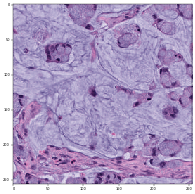

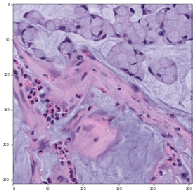

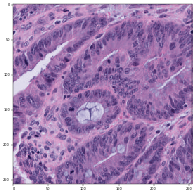

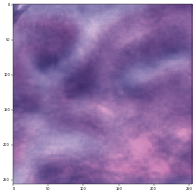

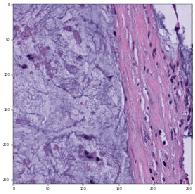

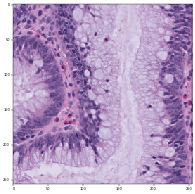

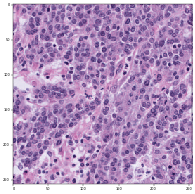

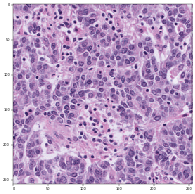

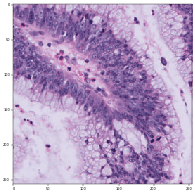

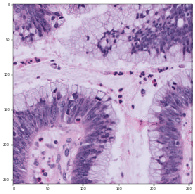

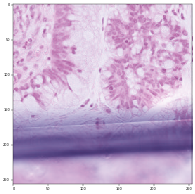

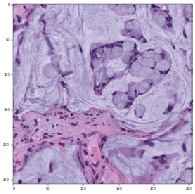

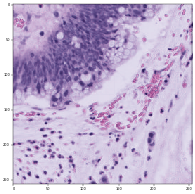

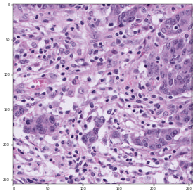

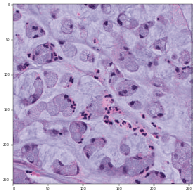

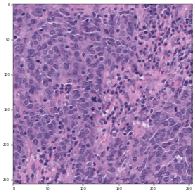

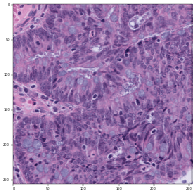

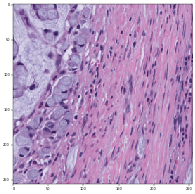

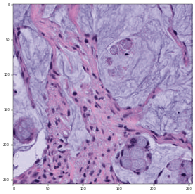

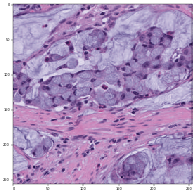

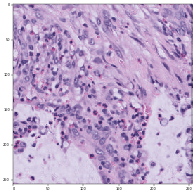

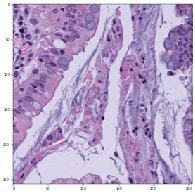

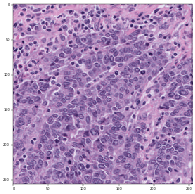

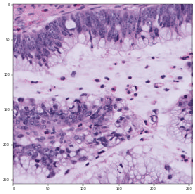

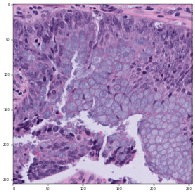

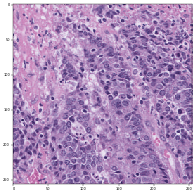

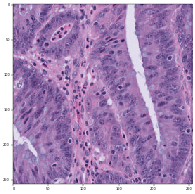

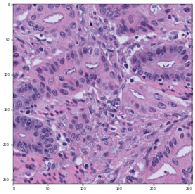

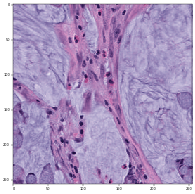

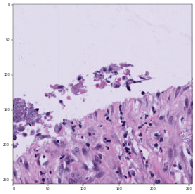

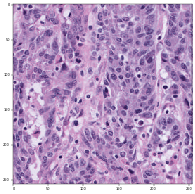

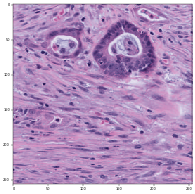

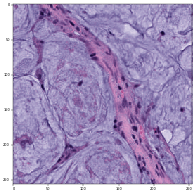

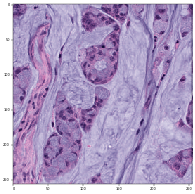

In [12]:
for idx, row in t2.sample(min(50, t2.shape[0])).iterrows():
    img = tifffile.imread('H:/' + row['file'])
    tifffile.imshow(img, dpi=32)

In [13]:
pd.set_option('display.max_rows', 500)

t['ft'] = t['umap1'] > 10
t2 = t[['wsi', 'msi', 'ft']].groupby(['wsi', 'msi'])['ft'].mean().sort_values().to_frame()
t2

ft
wsi              msi          
training_data_01 1    0.000000
training_data_45 0    0.000000
training_data_41 0    0.000000
training_data_40 0    0.000000
training_data_39 0    0.000000
training_data_38 0    0.000000
training_data_37 0    0.000000
training_data_33 0    0.000000
training_data_30 1    0.000000
training_data_29 0    0.000000
training_data_27 0    0.000000
training_data_46 0    0.000000
training_data_23 0    0.000000
training_data_21 0    0.000000
training_data_19 0    0.000000
training_data_18 0    0.000000
training_data_24 1    0.000000
training_data_16 0    0.000000
training_data_07 0    0.000000
training_data_08 0    0.000000
training_data_04 0    0.000000
training_data_03 0    0.000000
training_data_10 0    0.000000
training_data_06 1    0.000000
training_data_11 0    0.000000
training_data_05 1    0.000000
training_data_14 0    0.000000
training_data_15 0    0.000000
training_data_13 0    0.000394
training_data_34 1    0.000651
training_data_36 0    0.000952
training_data_25 0    0.001036
training_data_12 1    0.001091
training_data_02 0    0.001306
training_data_17 0    0.001361
training_data_44 1    0.001826
training_data_20 1    0.001935
training_data_35 0    0.002370
training_data_22 0    0.002491
training_data_32 1    0.004723
training_data_09 0    0.005447
training_data_43 0    0.008097
training_data_26 0    0.018966
training_data_28 0    0.026087
training_data_31 0    0.955801
training_data_47 1    0.983471
training_data_42 1    0.993117

# search

In [30]:
def random_search():
    query_idx = random.randint(0, df.shape[0])
    query_feature = feature[query_idx]
    query_img = tifffile.imread('H:/' + df['file'].iloc[query_idx])

    # search
    dist = np.sum((feature - query_feature) ** 2, axis=1)
    match_idx = np.argsort(dist)[1]
    match_img = tifffile.imread('H:/' + df['file'].iloc[match_idx])

    query_wsi = df['wsi'].iloc[query_idx]
    match_wsi = df['wsi'].iloc[match_idx]

    if query_wsi != match_wsi:
        print(query_idx, query_wsi, df['msi'].iloc[query_idx])
        print(match_idx, match_wsi, df['msi'].iloc[match_idx])

        # tifffile.imshow(query_img, dpi=32)
        # tifffile.imshow(match_img, dpi=32)

        fig, ax = plt.subplots(1,2)
        ax[0].imshow(query_img)
        ax[1].imshow(match_img)
        
    return query_wsi == match_wsi

75420 validation_data_10 0
92430 validation_data_21 0


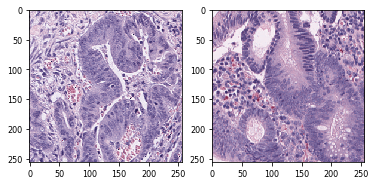

In [66]:
while random_search():
    continue